In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
pbp = pd.read_csv('../../Data/play-by-play/pbp_exp10.csv')

In [ ]:
# List of categorical columns
categorical_cols = [
    'OffenseTeam', 'DefenseTeam', 'play_type', 'side_of_field', 'stadium', 
    'play_type_nfl', 'roof', 'surface_type', 'home_team', 'away_team', 
    'season_type', 'offense_formation', 'temperature_grade', 'temperature_bucket'
]

# Dictionary to hold LabelEncoders for each column
label_encoders = {}

# Apply LabelEncoder to each categorical column and store encoders
for col in categorical_cols:
    le = LabelEncoder()
    pbp[col] = le.fit_transform(pbp[col].astype(str))  # Ensure the column is treated as a string
    label_encoders[col] = le 

## Experiment 10 - testing with additional feature engineering

Confusion Matrix for fold 1:
[[1233  386]
 [1006  613]]


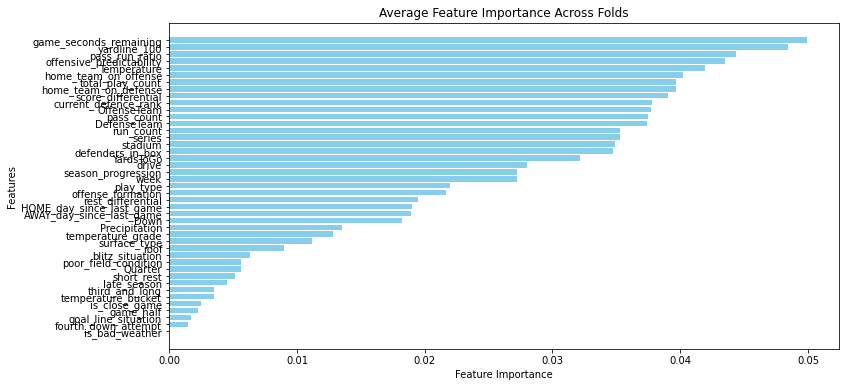

Accuracy scores for each fold: [0.5630018529956763, 0.5701050030883261, 0.541383570105003, 0.4431747992588017, 0.5821494749845584, 0.5231624459542927, 0.5784434836318715, 0.5379864113650401, 0.5342804200123533, 0.5138974675725757, 0.5818406423718344, 0.46849907350216186, 0.5444718962322421, 0.5203829524397776, 0.5707226683137739, 0.6019147621988882, 0.41321803582458305, 0.4975293390982088, 0.6195182211241507, 0.5778258184064237, 0.5509573810994441, 0.5886349598517604, 0.5015441630636195, 0.5901791229153799, 0.6466954910438543, 0.557442865966646, 0.5203829524397776, 0.5364422483014206, 0.5790611488573193, 0.4873378628783199, 0.612415071031501, 0.5747374922791847, 0.5197652872143298, 0.5565163681284744, 0.5836936380481779, 0.5281037677578753, 0.5379864113650401, 0.5247066090179123, 0.5620753551575046, 0.4820877084620136, 0.5410747374922792, 0.6571957998764669, 0.634342186534898, 0.5250154416306362, 0.5978999382334774, 0.5494132180358245, 0.5883261272390364, 0.618591723285979, 0.629709697

In [ ]:
X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense', 'season_progression',
               'defenders_in_box', 'offense_formation', 'Temperature', 'Precipitation', 'goal_line_situation',
               'pass_count', 'run_count', 'current_defence_rank','temperature_grade', 'temperature_bucket',
               'late_season','is_close_game', 'is_bad_weather', 'poor_field_condition', 'rest_differential', 'blitz_situation',
               'short_rest','pass_run_ratio', 'offensive_predictability', 'fourth_down_attempt', 'third_and_long']]


y = pbp['Player-Injured-On-Play']

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
feature_importances = np.zeros(X.shape[1])

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train RandomForest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict & Evaluate
    y_pred = rf_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

    # Store feature importances
    feature_importances += rf_model.feature_importances_

    # Get confusion matrix for a specific fold
    if fold == 1: 
        cm = confusion_matrix(y_test_resampled, y_pred)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6), facecolor='white')
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

Confusion Matrix for fold 1:
[[ 886  733]
 [ 491 1128]]


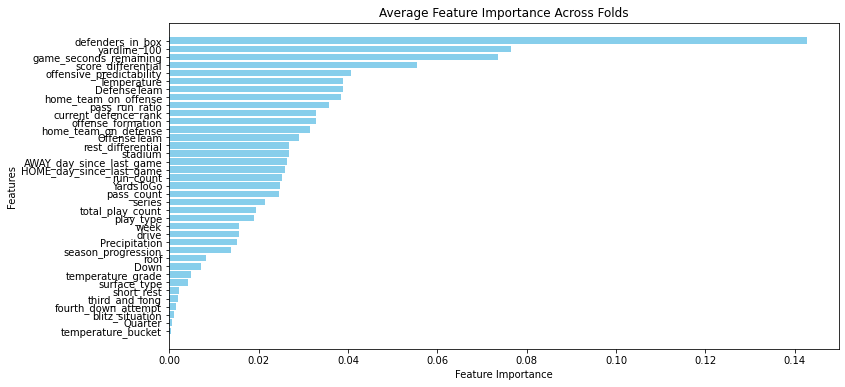

Accuracy scores for each fold: [0.6399011735639284, 0.6219888820259419, 0.5660901791229154, 0.5277949351451513, 0.6451513279802347, 0.5623841877702286, 0.608709079678814, 0.5271772699197035, 0.516059295861643, 0.5951204447189623, 0.5697961704756023, 0.6009882643607165, 0.5555898702903026, 0.5775169857936998, 0.5784434836318715, 0.5642371834465719, 0.5552810376775787, 0.5250154416306362, 0.7134033353922175, 0.5253242742433601, 0.5920321185917233, 0.6395923409512044, 0.5108091414453366, 0.6093267449042619, 0.6321803582458307, 0.567325509573811, 0.5342804200123533, 0.6408276714021001, 0.6294008647313156, 0.5790611488573193, 0.6383570105003088, 0.6179740580605312, 0.5602223594811612, 0.6056207535515751, 0.6331068560840025, 0.62816553428042, 0.5818406423718344, 0.6534898085237801, 0.6726374305126621, 0.5228536133415689, 0.5651636812847437, 0.634651019147622, 0.5945027794935145, 0.6111797405806053, 0.5487955528103767, 0.6463866584311303, 0.637739345274861, 0.634651019147622, 0.69919703520691

In [ ]:
X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense', 'season_progression',
               'defenders_in_box', 'offense_formation', 'Temperature', 'Precipitation',
               'pass_count', 'run_count', 'current_defence_rank','temperature_grade', 'temperature_bucket',
               'rest_differential', 'blitz_situation',
               'short_rest','pass_run_ratio', 'offensive_predictability', 'fourth_down_attempt', 'third_and_long']]


y = pbp['Player-Injured-On-Play']

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
feature_importances = np.zeros(X.shape[1])

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train RandomForest model
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict & Evaluate
    y_pred = gb_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

    # Store feature importances
    feature_importances += gb_model.feature_importances_

    # Get confusion matrix for a specific fold
    if fold == 1: 
        cm = confusion_matrix(y_test_resampled, y_pred)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6), facecolor='white')
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')

## Experiment 11 - testing with hyperparameter tuning

Processing fold 1/53
Confusion Matrix for fold 1:
[[1079  540]
 [ 715  904]]
Accuracy: 0.6124, Precision: 0.6260, Recall: 0.5584, F1: 0.5903
--------------------------------------------------
Processing fold 2/53
Confusion Matrix for fold 2:
[[1079  540]
 [ 599 1020]]
Accuracy: 0.6482, Precision: 0.6538, Recall: 0.6300, F1: 0.6417
--------------------------------------------------
Processing fold 3/53
Confusion Matrix for fold 3:
[[1098  521]
 [ 914  705]]
Accuracy: 0.5568, Precision: 0.5750, Recall: 0.4355, F1: 0.4956
--------------------------------------------------
Processing fold 4/53
Confusion Matrix for fold 4:
[[1037  582]
 [1109  510]]
Accuracy: 0.4778, Precision: 0.4670, Recall: 0.3150, F1: 0.3762
--------------------------------------------------
Processing fold 5/53
Confusion Matrix for fold 5:
[[1074  545]
 [ 578 1041]]
Accuracy: 0.6532, Precision: 0.6564, Recall: 0.6430, F1: 0.6496
--------------------------------------------------
Processing fold 6/53
Confusion Matrix fo

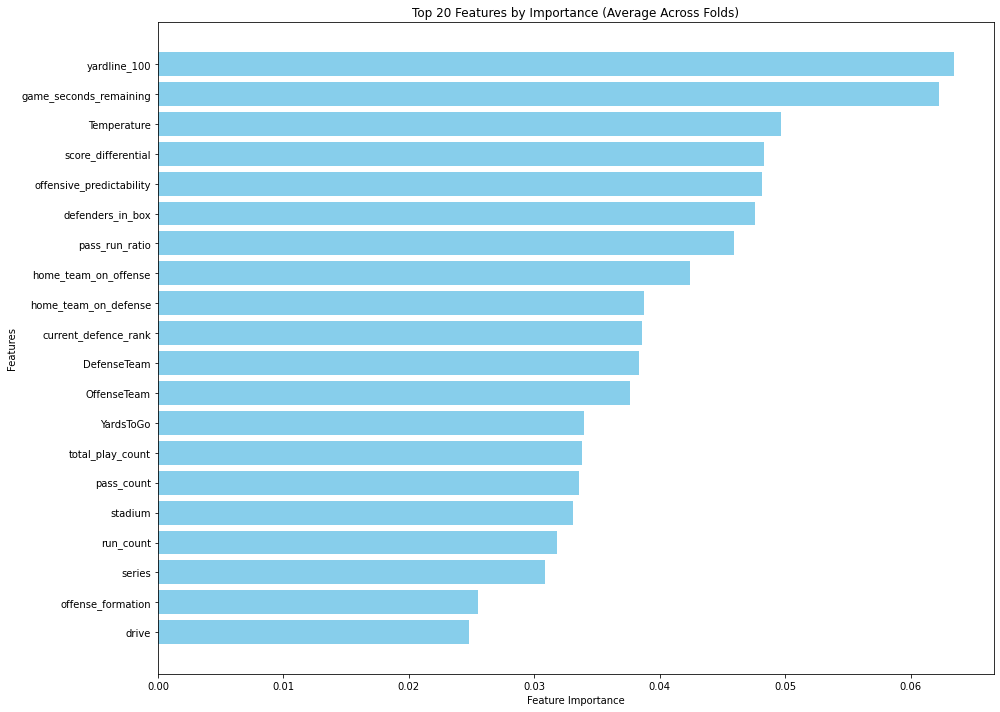


Cross-validation Results:
Mean Accuracy: 0.5637 (±0.0507)
Mean Precision: 0.5742 (±0.0562)
Mean Recall: 0.4581 (±0.0994)
Mean F1 Score: 0.5077 (±0.0827)


In [ ]:
# Define Features and Target
X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
         'Quarter', 'game_seconds_remaining', 'drive', 'series', 'score_differential',
         'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
         'total_play_count', 'home_team_on_offense', 'home_team_on_defense', 'season_progression',
         'defenders_in_box', 'offense_formation', 'Temperature', 'Precipitation',
         'pass_count', 'run_count', 'current_defence_rank', 'temperature_grade', 'temperature_bucket',
         'rest_differential', 'blitz_situation', 'short_rest', 'pass_run_ratio', 'offensive_predictability',
         'fourth_down_attempt', 'third_and_long']]

y = pbp['Player-Injured-On-Play']

# Define Stratified K-Fold Cross Validation
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = np.zeros(X.shape[1])

# Function to resample data to balance the dataset
def resample_data(X_data, y_data, sample_size=1619, replace_pos=True, replace_neg=False):
    X_pos = X_data[y_data == 1]
    X_neg = X_data[y_data == 0]
    y_pos = y_data[y_data == 1]
    y_neg = y_data[y_data == 0]
    
    X_pos_resampled, y_pos_resampled = resample(X_pos, y_pos, replace=replace_pos, n_samples=sample_size, random_state=42)
    X_neg_resampled, y_neg_resampled = resample(X_neg, y_neg, replace=replace_neg, n_samples=sample_size, random_state=42)
    
    X_resampled = pd.concat([X_pos_resampled, X_neg_resampled])
    y_resampled = pd.concat([y_pos_resampled, y_neg_resampled])
    
    return X_resampled, y_resampled

# Perform Stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Processing fold {fold + 1}/{k}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Resample training data for balance
    X_train_resampled, y_train_resampled = resample_data(X_train, y_train)
    
    # Define the Gradient Boosting model
    gb_base = GradientBoostingClassifier(random_state=42)
    
    # Hyperparameter grid 
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0],
        'max_features': ['sqrt', 'log2', None]
    }

    # Use RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=gb_base,
        param_distributions=param_grid,
        n_iter=20,
        cv=3,
        verbose=0,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the model with RandomizedSearchCV
    random_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the best model
    best_model = random_search.best_estimator_
    
    # Resample test data for balanced evaluation
    X_test_resampled, y_test_resampled = resample_data(X_test, y_test)
    
    # Predict and evaluate the model
    y_pred = best_model.predict(X_test_resampled)
    
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)
    f1 = f1_score(y_test_resampled, y_pred)
    
    # Store results
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    # Store feature importances
    feature_importances += best_model.feature_importances_
    
    # Print confusion matrix for the current fold
    cm = confusion_matrix(y_test_resampled, y_pred)
    print(f'Confusion Matrix for fold {fold + 1}:')
    print(cm)
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
    print('-' * 50)

# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(14, 10), facecolor='white')
plt.barh(sorted_features[:20], sorted_importances[:20], color='skyblue')  # Show top 20 features
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Features by Importance (Average Across Folds)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print cross-validation results
print("\nCross-validation Results:")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f} (±{np.std(accuracy_scores):.4f})')
print(f'Mean Precision: {np.mean(precision_scores):.4f} (±{np.std(precision_scores):.4f})')
print(f'Mean Recall: {np.mean(recall_scores):.4f} (±{np.std(recall_scores):.4f})')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})')

Processing fold 1/53
Best parameters for fold 1: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Confusion Matrix for fold 1:
[[1174  445]
 [ 847  772]]
Accuracy: 0.6010, Precision: 0.6343, Recall: 0.4768, F1: 0.5444
--------------------------------------------------
Processing fold 2/53
Best parameters for fold 2: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Confusion Matrix for fold 2:
[[1173  446]
 [ 843  776]]
Accuracy: 0.6019, Precision: 0.6350, Recall: 0.4793, F1: 0.5463
--------------------------------------------------
Processing fold 3/53
Best parameters for fold 3: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Confusion Matrix for fold 3:
[[1170  449]
 [1045  574]]
Accuracy: 0.5386, Precision: 0.5611, Recall: 0.3545, F1: 0.4345
----

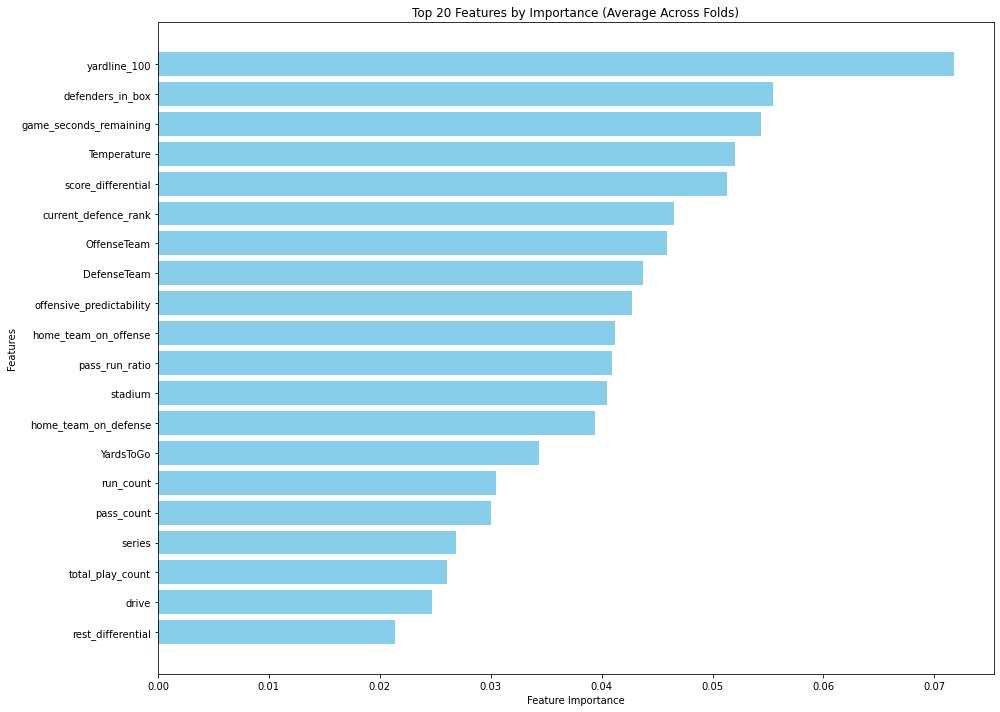

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Define features and target
X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
         'Quarter', 'game_seconds_remaining', 'drive', 'series', 'score_differential',
         'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
         'total_play_count', 'home_team_on_offense', 'home_team_on_defense', 'season_progression',
         'defenders_in_box', 'offense_formation', 'Temperature', 'Precipitation',
         'pass_count', 'run_count', 'current_defence_rank','temperature_grade', 'temperature_bucket',
         'rest_differential', 'blitz_situation',
         'short_rest','pass_run_ratio', 'offensive_predictability', 'fourth_down_attempt', 'third_and_long']]

y = pbp['Player-Injured-On-Play']

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
best_models = []
feature_importances = np.zeros(X.shape[1])

# Function to resample data for balancing
def resample_data(X_data, y_data, sample_size=1619, replace_pos=True, replace_neg=False):
    # Separate injured and non-injured plays
    X_pos = X_data[y_data == 1]
    X_neg = X_data[y_data == 0]
    y_pos = y_data[y_data == 1]
    y_neg = y_data[y_data == 0]
    
    # Resample
    X_pos_resampled, y_pos_resampled = resample(X_pos, y_pos, replace=replace_pos, n_samples=sample_size, random_state=42)
    X_neg_resampled, y_neg_resampled = resample(X_neg, y_neg, replace=replace_neg, n_samples=sample_size, random_state=42)
    
    # Combine resampled data
    X_resampled = pd.concat([X_pos_resampled, X_neg_resampled])
    y_resampled = pd.concat([y_pos_resampled, y_neg_resampled])
    
    return X_resampled, y_resampled

# Perform stratified K-Fold cross-validation with hyperparameter tuning
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Processing fold {fold+1}/{k}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Resample training data for balance
    X_train_resampled, y_train_resampled = resample_data(X_train, y_train)
    
    # Define the model with RandomizedSearchCV for hyperparameter tuning
    rf_base = RandomForestClassifier(random_state=42)
    
    # Use RandomizedSearchCV instead of GridSearchCV for efficiency
    random_search = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter settings sampled
        cv=3,       # Inner cross-validation
        verbose=0,
        random_state=42,
        n_jobs=-1   # Use all available cores
    )
    
    # Fit the randomized search
    random_search.fit(X_train_resampled, y_train_resampled)
    
    # Get the best model
    best_model = random_search.best_estimator_
    best_models.append(best_model)
    
    # Save best parameters for this fold
    print(f"Best parameters for fold {fold+1}: {random_search.best_params_}")
    
    # Resample test data for balanced evaluation
    X_test_resampled, y_test_resampled = resample_data(X_test, y_test)
    
    # Predict & Evaluate
    y_pred = best_model.predict(X_test_resampled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)
    f1 = f1_score(y_test_resampled, y_pred)
    
    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    # Store feature importances
    feature_importances += best_model.feature_importances_
    
    # Get confusion matrix
    cm = confusion_matrix(y_test_resampled, y_pred)
    print(f'Confusion Matrix for fold {fold+1}:')
    print(cm)
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
    print('-' * 50)

# Compute average feature importance
feature_importances /= k

# Identify the most common best parameters across folds
param_keys = list(param_grid.keys())
best_params_counts = {key: {} for key in param_keys}

for model in best_models:
    for param_key in param_keys:
        param_value = getattr(model, param_key)
        if param_value in best_params_counts[param_key]:
            best_params_counts[param_key][param_value] += 1
        else:
            best_params_counts[param_key][param_value] = 1

# Find most common value for each parameter
most_common_params = {}
for param_key, value_counts in best_params_counts.items():
    most_common_value = max(value_counts.items(), key=lambda x: x[1])[0]
    most_common_params[param_key] = most_common_value

print("\nMost common best parameters across folds:")
for param, value in most_common_params.items():
    print(f"{param}: {value}")

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(14, 10), facecolor='white')
plt.barh(sorted_features[:20], sorted_importances[:20], color='skyblue')  # Show top 20 features
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Features by Importance (Average Across Folds)')
plt.gca().invert_yaxis()
plt.tight_layout()

# Print cross-validation results
print("\nCross-validation Results:")
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f} (±{np.std(accuracy_scores):.4f})')
print(f'Mean Precision: {np.mean(precision_scores):.4f} (±{np.std(precision_scores):.4f})')
print(f'Mean Recall: {np.mean(recall_scores):.4f} (±{np.std(recall_scores):.4f})')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})')